# Exercise 6

This week we will practice how to work with OpenStreetMap data and conduct network analysis in Python.

## Problem 1 (8 points)

There are two csv-files in the [/data](./data) folder:

- `origins.csv`
- `destinations.csv`

The files contain coordinates of the origin and destination points in certain area of the world as latitude and longitude coordinates (decimal degrees). 

**1: Your task is to find out where the points are located based on the coordinates found in the files** (which city/country?) Use your GIS skills to find out the solution in two different ways.

A. detect the location using **visualization techniques**; plot the points on top of a background map and see where they are located! 

In [1]:
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import CRS
from geopy.geocoders import Nominatim
import osmnx as ox

In [2]:
origins = pd.read_csv('data/origins.csv')
origins.head()

,x,y
0,24.6159,59.4052
1,24.6407,59.4074
2,24.6686,59.4018
3,24.6980,59.4477
4,24.7680,59.4303


In [3]:
destinations = pd.read_csv('data/destinations.csv')
destinations.head()

,x,y
0,24.8441,59.4395
1,24.6150,59.3433
2,24.8656,59.4405
3,24.6983,59.4013
4,24.7630,59.4407


In [68]:
# create a geodataframe with the points
points = []
points.extend([{'geometry': Point(row['x'], row['y']), \
                'type': 'origin'} for _, row in origins.iterrows()])
points.extend([{'geometry': Point(row['x'], row['y']), \
                'type': 'destination'} for _, row in destinations.iterrows()])

df = gpd.GeoDataFrame(points, crs=CRS.from_epsg(4326)) # a common CRS in longitude and latitude
df.head()

,geometry,type
0,POINT (24.61590 59.40520),origin
1,POINT (24.64070 59.40740),origin
2,POINT (24.66860 59.40180),origin
3,POINT (24.69800 59.44770),origin
4,POINT (24.76800 59.43030),origin


In [69]:
# reproject the points to web mercator to play well with the base map
df = df.to_crs(epsg=3857)

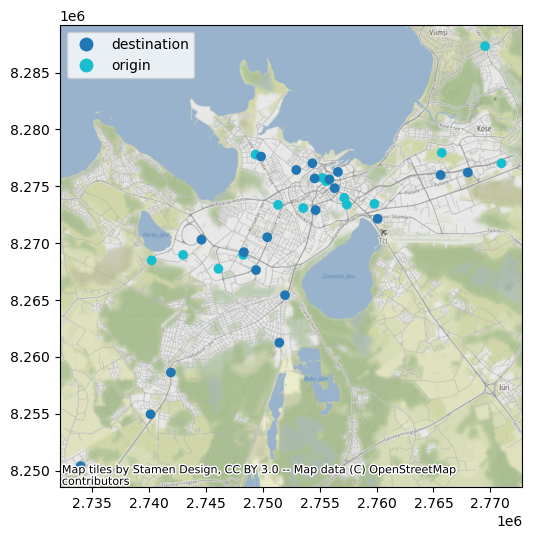

In [70]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
df.plot(ax=ax, column='type', legend=True)
ctx.add_basemap(ax, crs=df.crs)

**I think we're in Estonia.**

B. Detect the location using **geocoding techniques**; reverse geocode at least one of the locations (see [hints from geopy documentation](https://geopy.readthedocs.io/en/stable/index.html?highlight=reverse#module-geopy.geocoders)). As output, you should print out information about the location (can be a full address, or just the name of the city):

In [12]:
# the geolocator seems to like points in the y, x format
geolocator = Nominatim(user_agent="autogis-2021")
location = geolocator.reverse(f"{origins.at[3, 'y']}, {origins.at[3, 'x']}")
print(location.address)

Grossi, 3, Kari, Pelguranna, Põhja-Tallinna linnaosa, Tallinn, Harju maakond, 10311, Eesti


In [13]:
print(location.raw)

{'place_id': 111015158, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 26914368, 'lat': '59.447688799999995', 'lon': '24.69787590077248', 'display_name': 'Grossi, 3, Kari, Pelguranna, Põhja-Tallinna linnaosa, Tallinn, Harju maakond, 10311, Eesti', 'address': {'shop': 'Grossi', 'house_number': '3', 'road': 'Kari', 'quarter': 'Pelguranna', 'suburb': 'Põhja-Tallinna linnaosa', 'city': 'Tallinn', 'municipality': 'Tallinn', 'county': 'Harju maakond', 'ISO3166-2-lvl6': 'EE-37', 'postcode': '10311', 'country': 'Eesti', 'country_code': 'ee'}, 'boundingbox': ['59.4476083', '59.4478214', '24.6975133', '24.6983005']}


**Yup, we're in Estonia.**

**2: Retrieve OpenStreetMap data (only streets that can be driven with car) from the area where the points are located.**

- Specify a Polygon that covers the **extent where all the points are located*. 
- Store the extent as a Shapely Polygon stored in a variable called `graph_extent`.
- Add a little bit of buffer around the extent for downloading the graph, so that you cover all routes between the points.
- See hints from this [week's hints page](https://autogis-site.readthedocs.io/en/latest/lessons/L6/exercise-6.html#hints) on how to define the extent.

In [32]:
# Re-project the points to a local projected CRS so that we can have it in meters
projected_df = df.to_crs(epsg=3301)

# create a union of all of the points and then a convex hull of that union
convex_hull = projected_df['geometry'].unary_union.convex_hull

projected_df.crs

<Derived Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
# add a 200 meter buffer around the polygon
graph_extent = convex_hull.buffer(200)

In [34]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(graph_extent)

POLYGON ((531979.9731460518 6575993.340945243, 531962.8594593666 6575983.644866605, 531944.8761019364 6575975.676738315, 531926.1970142849 6575969.513630544, 531907.002866251 6575965.215154749, 531887.4793094948 6575962.822887103, 531867.8151818183 6575962.359966348, 531848.2006806682 6575963.830869995, 531828.8255234886 6575967.221371015, 531809.8771127152 6575972.498675446, 531791.5387231624 6575979.61173959, 531773.9877293331 6575988.4917637175, 531757.3938897984 6575999.052857525, 531741.9177052407 6576011.192870887, 531727.7088660422 6576024.7943818895, 531714.904804434 6576039.725832564, 531703.6293652095 6576055.84280136, 531693.9916078591 6576072.989400037, 531686.084751715 6576090.999781454, 531679.9852743036 6576109.699743706, 531675.752171633 6576128.9084150465, 531673.4263875644 6576148.440003343, 531673.0304177916 6576168.105593109, 531674.5680922552 6576187.714972756, 531678.0245380981 6576207.078474377, 531683.366323521 6576226.008808273, 534792.7136146517 6585477.708573

In [35]:
# NON-EDITABLE TEST CELL
# The extent should be a shapely Polygon
print(type(graph_extent))

<class 'shapely.geometry.polygon.Polygon'>


- Use the polygon to fetch the drivable network data with `.graph_from_polygon()` function 
- Remember to specify correct `network_type`
- see [osmnx docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_polygon) for more details
- store the street network a variable called `graph`

In [40]:
# Re-project the polygon back to WGS84, as required by osmnx
place_polygon = gpd.GeoDataFrame([{'geometry': graph_extent}], crs=projected_df.crs)
place_polygon = place_polygon.to_crs(epsg=4326)
graph_extent = place_polygon["geometry"].values[0]

In [41]:
# Retrieve the driving network using the polygon we created
graph = ox.graph_from_polygon(graph_extent, network_type='drive')

In [42]:
# NON-EDITABLE TEST CELL
# The graph should be a networkx MultiDiGraph
print(type(graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [43]:
# NON-EDITABLE TEST CELL
# Check the graph size. The example solution graph size is 28756 (don't panic if yours is not exactly the same, you can still proceed!)
print(graph.size())

14133


**3: Reproject the data into UTM projection, and plot:**
  - the street network (with `gray` color and line width of `0.5` and alpha set to `0.7`)
  - the origin points (with `red` color)
  - destination points (with `blue` color)
  
In the end you should have a map that looks something like following:

![](img/route_network_with_OD_points.png)

In [97]:
# Project the data into UTM
graph_proj = ox.project_graph(graph) 

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [107]:
# project the original points data to the same crs as the edges
projected_df = projected_df.to_crs(edges_proj.crs)

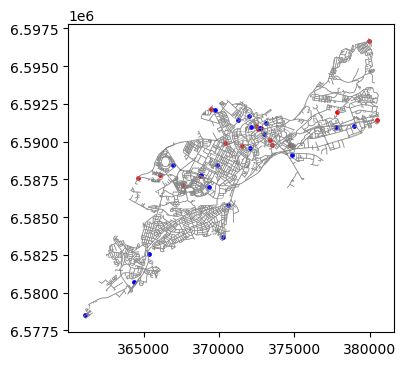

In [108]:
fig, ax = plt.subplots(figsize=(10,4))
edges_proj.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.7)
projected_df[projected_df['type'] == 'origin'].plot(ax=ax, color='red', markersize=6)
projected_df[projected_df['type'] == 'destination'].plot(ax=ax, color='blue', markersize=6)
plt.show()

### Done!

That's it! Now you can continue with problem 2. 

## Problem 2 (12 points)

In this problem we practice conducting shortest path routing.

### Steps

**1: Calculate the shortest paths between all origin points (16) and destination points (20) using the `length` of the road segments as the impedance measure (in total 320 routes).** 

- To be able to find the shortest paths, you should find the nearest nodes from the graph for both origin and destination points. 
- Notice: if the closest node is the same for both origin and destination point, you should skip the shortest path calculation. - After the routing, you should add the shortest path routes as LineString geometries into a GeoDataFrame called `routes`. 
- You should use the projected graph as the network for the analyses
- remember to use informative variable names, and to comment your code!

In [77]:
from itertools import product
import numpy as np

In [109]:
projected_df.head()

,geometry,type,nearest_node
0,POINT (364659.492 6587597.013),origin,341986868
1,POINT (366075.637 6587791.721),origin,297425570
2,POINT (367637.096 6587112.547),origin,10142975933
3,POINT (369482.650 6592163.774),origin,1769386593
4,POINT (373385.475 6590091.584),origin,10580988


In [110]:
projected_df['nearest_node'] = projected_df.apply(lambda row: ox.distance.nearest_nodes(graph_proj, \
                                                                                        row['geometry'].x, \
                                                                                        row['geometry'].y), \
                                                  axis=1)
projected_df.head()

,geometry,type,nearest_node
0,POINT (364659.492 6587597.013),origin,341986868
1,POINT (366075.637 6587791.721),origin,297425570
2,POINT (367637.096 6587112.547),origin,10142975933
3,POINT (369482.650 6592163.774),origin,1769386593
4,POINT (373385.475 6590091.584),origin,10580988


In [111]:
print(f'The number of points: {len(projected_df)}')

The number of points: 36


In [112]:
# find the origin and destination combinations where the origin
# and destination aren't the same
point_combos = np.array([(a,b) for a,b in product(projected_df[projected_df['type'] == 'origin']['nearest_node'], \
                                                  projected_df[projected_df['type'] == 'destination']['nearest_node']) if a != b])
print(f'Number of combos found: {len(point_combos):,}')

Number of combos found: 319


In [113]:
shortest_paths = ox.distance.shortest_path(graph_proj, \
                                           point_combos[:,0], point_combos[:,1], \
                                           weight='length')
type(shortest_paths), len(shortest_paths)

(list, 319)

In [114]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
10578472,6.589958e+06,370852.709172,3,24.723472,59.428335,NaN,POINT (370852.709 6589958.451)
75704748,6.589907e+06,370804.047125,5,24.722646,59.427859,NaN,POINT (370804.047 6589907.046)
243943723,6.590018e+06,370829.561097,3,24.723029,59.428861,NaN,POINT (370829.561 6590017.886)
10578481,6.591150e+06,370719.577422,3,24.720409,59.438986,NaN,POINT (370719.577 6591150.046)
10578496,6.590969e+06,370880.236974,3,24.723348,59.437414,NaN,POINT (370880.237 6590969.305)


In [124]:
# Store the shortest path routes as LineString geometries in a GeoDataFrame called routes
# Some shortest paths are None, so don't include those
routes = gpd.GeoDataFrame([{'geometry': LineString([nodes_proj.at[node, 'geometry'] for node in path]), \
                            'origin_id': combo[0], \
                            'destination_id': combo[1]} for combo, path in zip(point_combos, shortest_paths) if path is not None], \
                          crs=nodes_proj.crs)

routes.head()

,geometry,origin_id,destination_id
0,"LINESTRING (364723.450 6587654.149, 364688.064...",341986868,614466115
1,"LINESTRING (364723.450 6587654.149, 365376.539...",341986868,3092027759
2,"LINESTRING (364723.450 6587654.149, 364688.064...",341986868,2571675809
3,"LINESTRING (364723.450 6587654.149, 365376.539...",341986868,11790828
4,"LINESTRING (364723.450 6587654.149, 364688.064...",341986868,790046528


**2: Calculate the distance of the routes in meters into a new column called `route_dist`.**
 

In [125]:
# make sure the crs is in meters
routes.crs

<Derived Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [126]:
routes['route_dist'] = routes['geometry'].length

In [127]:
# NON-EDITABLE TEST CELL
print("Shortest distance:", round(routes['route_dist'].min()), "meters")

Shortest distance: 279 meters


In [128]:
# NON-EDITABLE TEST CELL (longest distance in the example solution is 29177 meters)
print("Longest distance:", round(routes['route_dist'].max()), "meters")

Longest distance: 24524 meters


**3: Plot all the routes on top of the street network.** 

In the end you should have something like following:
 
 ![](img/routings.png)

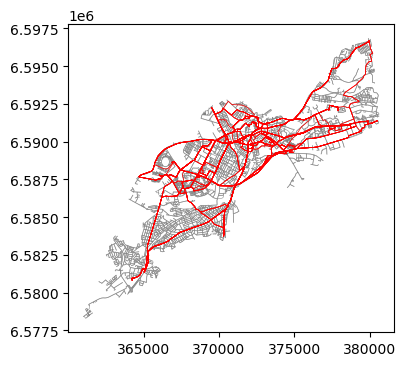

In [129]:
fig, ax = plt.subplots(figsize=(10,4))
edges_proj.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.7)
routes.plot(ax=ax, color='red', linewidth=0.5)
plt.show()

**4: Calculate the total distance of all the routes (i.e. sum of all route distances)** Update the `total_distance` based on your calculations:

In [130]:
total_distance = routes['route_dist'].sum()

In [131]:
# NON-EDITABLE TEST CELL (example solution: 2468 kilometers)
#Print your solution:
print("Total distance of all routes is: %.0f kilometers" % (total_distance / 1000))


Total distance of all routes is: 2168 kilometers


### Done!

That's it! Now you have finished all the practical exercises of the course (except final assignment), congratulations! :)